# White noise fitting example (EFAC and ECORR)

This notebook corresponds to Section 6.2 of Susobhanan+ 2024.

In [1]:
from enterprise.pulsar import Pulsar
from enterprise.signals.white_signals import MeasurementNoise, EcorrKernelNoise
from enterprise.signals.gp_signals import TimingModel
from enterprise.signals.signal_base import PTA
from enterprise.signals.parameter import Uniform, LinearExp
from enterprise.signals.selections import Selection, by_backend

from pint.models import get_model_and_toas
from pint.fitter import Fitter
from pint.logging import setup as setup_log
from pint.utils import akaike_information_criterion

from PTMCMCSampler.PTMCMCSampler import PTSampler

import numpy as np
import corner
import matplotlib.pyplot as plt
from copy import deepcopy

Optional mpi4py package is not installed.  MPI support is not available.
Optional acor package is not installed. Acor is optionally used to calculate the effective chain length for output in the chain file.


In [2]:
setup_log(level="WARNING")

1

In [3]:
m, t = get_model_and_toas("sim2.par", "sim2.tim", planets=True)

In [4]:
print(m)

# Created: 2024-04-23T12:53:46.239821
# PINT_version: 0.9.8+313.gbdb54a71
# User: Abhimanyu Susobhanan (abhimanyu)
# Host: abhimanyu-HP-Envy-x360-2-in-1-Laptop-15-fh0xxx
# OS: Linux-6.5.0-28-generic-x86_64-with-glibc2.35
# Python: 3.10.13 (main, Sep 11 2023, 13:44:35) [GCC 11.2.0]
# Format: pint
PSR                                  SIM1
EPHEM                               DE440
CLOCK                        TT(BIPM2019)
UNITS                                 TDB
DILATEFREQ                              N
DMDATA                                  N
NTOA                                    0
RAJ                      5:00:00.00000000 1 0.00000000000000000000
DECJ                    15:00:00.00000000 1 0.00000000000000000000
PMRA                                  0.0
PMDEC                                 0.0
PX                                    0.0
F0                                  100.0 1 0.0
F1                                 -1e-15 1 0.0
PEPOCH             55000.0000000000000000
PLANET_SHAP

In [5]:
result = np.zeros((2,2))
for eff in [True, False]:
    for ecf in [True, False]:
        m1 = deepcopy(m)
        m1.EFAC1.value = 1
        m1.ECORR1.value = 1e-3
        m1.EFAC1.frozen = not eff
        m1.ECORR1.frozen = not ecf

        ftr = Fitter.auto(t, m1)
        ftr.fit_toas(noise_fit_niter=5)

        fp = set(m1.free_params).intersection(["EFAC1", "ECORR1"])

        # print(ftr.model.EFAC1, ftr.model.ECORR1)
        
        result[int(not eff), int(not ecf)] = akaike_information_criterion(ftr.model, t)

np.round(result - np.min(result))

array([[   0.,  331.],
       [ 228., 1238.]])

In [6]:
ftr = Fitter.auto(t, m)
ftr.fit_toas(noise_fit_niter=5)

True

In [7]:
print(ftr.model)

# Created: 2024-04-23T12:56:13.677149
# PINT_version: 0.9.8+313.gbdb54a71
# User: Abhimanyu Susobhanan (abhimanyu)
# Host: abhimanyu-HP-Envy-x360-2-in-1-Laptop-15-fh0xxx
# OS: Linux-6.5.0-28-generic-x86_64-with-glibc2.35
# Python: 3.10.13 (main, Sep 11 2023, 13:44:35) [GCC 11.2.0]
# Format: pint
PSR                                  SIM1
EPHEM                               DE440
CLOCK                        TT(BIPM2019)
UNITS                                 TDB
START              53000.9999999566961806
FINISH             56985.0000000464502315
DILATEFREQ                              N
DMDATA                                  N
NTOA                                 2000
CHI2                   1999.9595319235289
CHI2R                  1.0039957489575948
TRES                1.5197086419660872211
RAJ                      5:00:00.00000104 1 0.00000309788366042071
DECJ                    14:59:59.99982230 1 0.00026526190479642364
PMRA                                  0.0
PMDEC                  

In [8]:
psr = Pulsar(ftr.model, t)

In [9]:
tm = TimingModel()
wn = MeasurementNoise(efac=Uniform(0.5, 2.0), selection=Selection(by_backend))
ec = EcorrKernelNoise(log10_ecorr=LinearExp(-8, -4), selection=Selection(by_backend))

In [10]:
model = tm + wn + ec

In [11]:
pta = PTA([model(psr)])

In [12]:
ndim = len(pta.param_names)
x0 = np.array([p.sample() for p in pta.params])
cov = np.diag(np.ones(ndim)) * 1e-4
outdir = "chains/sim2/"
Niter = 100000

In [13]:
sampler = PTSampler(
    ndim,
    pta.get_lnlikelihood,
    pta.get_lnprior,
    cov,
    outDir=outdir,
)

In [14]:
sampler.sample(
    x0,
    Niter,
)

Finished 1.00 percent in 18.865069 s Acceptance rate = 0.694

WARNING  (pint.logging                  ): /home/abhimanyu/miniconda3/envs/pint-noise/lib/python3.10/site-packages/enterprise/signals/parameter.py:62 RuntimeWarning: divide by zero encountered in log


Finished 10.00 percent in 178.951454 s Acceptance rate = 0.23242Adding DE jump with weight 20
Finished 99.00 percent in 1545.882547 s Acceptance rate = 0.351879
Run Complete


In [15]:
chain = np.genfromtxt(f"{outdir}/chain_1.txt")
burn = chain.shape[0]//5
burned_chain = chain[burn:, :-4]
burned_chain[:, 1] = 10**burned_chain[:, 1] * 1e6

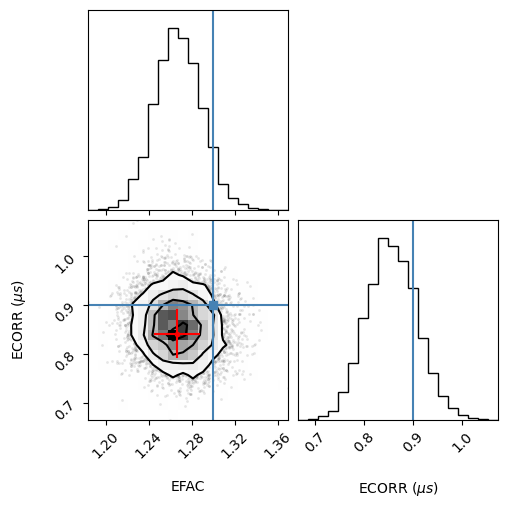

In [16]:
fig = corner.corner(
    burned_chain, 
    labels=["EFAC", "ECORR ($\\mu s$)"], 
    truths=[m.EFAC1.value, m.ECORR1.quantity.value],
)

plt.subplot(223)
plt.errorbar(
    [ftr.model.EFAC1.value], 
    [ftr.model.ECORR1.value],
    xerr=[ftr.model.EFAC1.uncertainty_value], 
    yerr=[ftr.model.ECORR1.uncertainty_value],
    color="red",
    marker="."
)
plt.savefig("sim2.pdf")
plt.show()

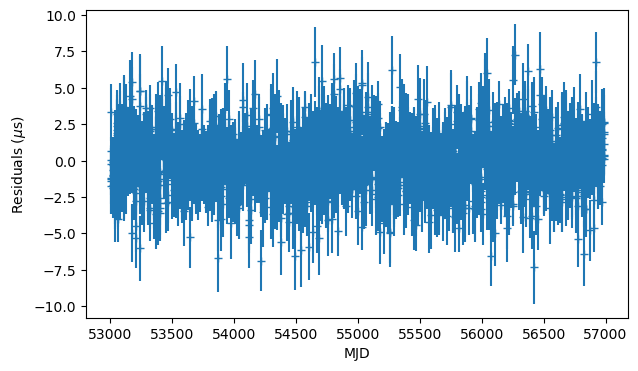

In [17]:
plt.figure(figsize=(7, 4))
plt.errorbar(ftr.toas.get_mjds(), ftr.resids.time_resids.to("us"), ftr.resids.get_data_error().to("us"), ls="", marker="+")
plt.ylabel("Residuals ($\\mu$s)")
plt.xlabel("MJD")
plt.savefig("sim2-resids.pdf")